# Multicollinearity Example
### White Wine Quality Dataset
#### Source:  https://archive.ics.uci.edu/ml/datasets/wine+Quality
Original Citation:  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

## Load Libraries & Data

In [1]:
import numpy as np 
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("winequality-white.csv", sep=';')
df.columns = [re.sub(' ', '_', x) for x in df.columns]

In [3]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
X_raw = df.drop('quality', axis=1)
y_raw = df[['quality']]

scaler = StandardScaler()
    
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns

## Correlation Matrix

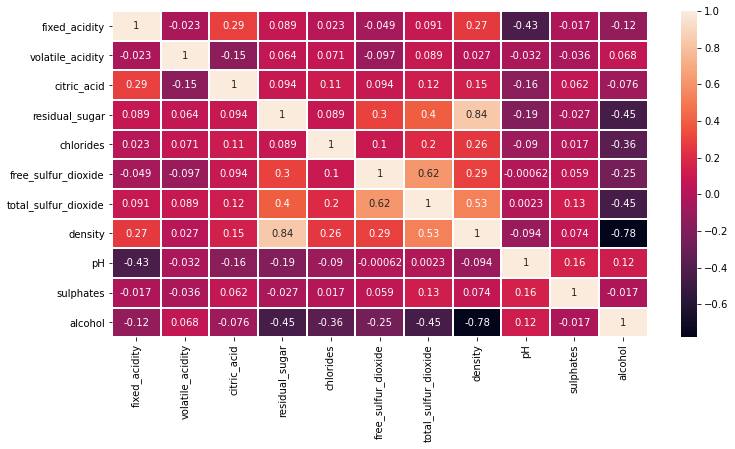

In [5]:
plt.figure(figsize=(12,6)) 
sns.heatmap(df_scaled.drop('quality', axis=1).corr(), linewidths=1, annot=True);

## VIF

In [6]:
vif_df = df_scaled.drop(['quality'], axis=1)

vif_vals = pd.DataFrame()
vif_vals["col_name"] = vif_df.columns
vif_vals["VIF"] = [variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))]

vif_vals.sort_values(by="VIF", ascending = False)

,col_name,VIF
7,density,28.232546
3,residual_sugar,12.644064
10,alcohol,7.706957
0,fixed_acidity,2.691435
6,total_sulfur_dioxide,2.239233
8,pH,2.196362
5,free_sulfur_dioxide,1.787880
4,chlorides,1.236822
2,citric_acid,1.165215
1,volatile_acidity,1.141156


In [7]:
# Remove multicollinear feature and re-evaluate
vif_df = df_scaled.drop(['quality', 'density'], axis=1)

vif_vals = pd.DataFrame()
vif_vals["col_name"] = vif_df.columns
vif_vals["VIF"] = [variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))]

vif_vals.sort_values(by="VIF", ascending = False)

,col_name,VIF
6,total_sulfur_dioxide,2.153170
5,free_sulfur_dioxide,1.744627
9,alcohol,1.647117
3,residual_sugar,1.435215
0,fixed_acidity,1.356128
7,pH,1.330912
4,chlorides,1.203645
2,citric_acid,1.159884
1,volatile_acidity,1.128298
8,sulphates,1.056637


## Ordinary Least Squares Linear Regression
### Raw Data

In [8]:
X_raw.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.20, random_state=56)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [10]:
X_train = pd.DataFrame(X_train)
X_train.columns = X_raw.columns

y_train = pd.DataFrame(y_train)
y_train.columns = y_raw.columns

In [11]:
# sklearn Linear Regression
skl_model = LinearRegression().fit(X_train, y_train)

# Statsmodels OLS
stats_model = OLS(endog=y_train, exog=X_train)
stats_model_results = stats_model.fit()
print(stats_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.286
Model:                            OLS   Adj. R-squared (uncentered):              0.284
Method:                 Least Squares   F-statistic:                              142.5
Date:                Thu, 13 Oct 2022   Prob (F-statistic):                   3.21e-276
Time:                        08:01:04   Log-Likelihood:                         -4898.7
No. Observations:                3918   AIC:                                      9819.
Df Residuals:                    3907   BIC:                                      9888.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

#### Evaluate - Train

In [12]:
skl_model.score(X_train, y_train)

0.28628929881702214

In [13]:
stats_model_results.rsquared

0.2862892988170219

In [14]:
y_pred = skl_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8448140038984782

In [15]:
y_pred = stats_model_results.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8448140038984782

#### Evaluate - Test - RMSE

In [16]:
skl_model.score(X_test, y_test)

0.25727187148283504

In [17]:
y_pred = skl_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.8741340992285125

In [18]:
y_pred = stats_model_results.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.8741340992285126

### Multicollinearity Removed ("density" Feature Removed)

In [19]:
X_adjusted = X_raw.drop('density', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_adjusted, y_raw, test_size=0.20, random_state=56)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)


X_train = pd.DataFrame(X_train)
X_train.columns = X_raw.drop('density', axis=1).columns

y_train = pd.DataFrame(y_train)
y_train.columns = y_raw.columns

# sklearn Linear Regression
skl_model = LinearRegression().fit(X_train, y_train)

# Statsmodels OLS
stats_model = OLS(endog=y_train, exog=X_train)
stats_model_results = stats_model.fit()
print(stats_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.276
Model:                            OLS   Adj. R-squared (uncentered):              0.274
Method:                 Least Squares   F-statistic:                              148.7
Date:                Thu, 13 Oct 2022   Prob (F-statistic):                   6.97e-265
Time:                        08:01:04   Log-Likelihood:                         -4927.6
No. Observations:                3918   AIC:                                      9875.
Df Residuals:                    3908   BIC:                                      9938.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

#### Evaluate - Train

In [20]:
skl_model.score(X_train, y_train)

0.27568898444249

In [21]:
stats_model_results.rsquared

0.2756889844424901

In [22]:
y_pred = skl_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8510646365332718

In [23]:
y_pred = stats_model_results.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8510646365332718

#### Evaluate - Test

In [24]:
skl_model.score(X_test, y_test)

0.25858414629348736

In [25]:
y_pred = skl_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.8733615343771978

In [26]:
y_pred = stats_model_results.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.8733615343771977

### Multicollinearity Removed (PCA)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.20, random_state=56)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [28]:
pca = PCA(n_components = X_train.shape[1])
X_train_pca = pca.fit_transform(X_train)

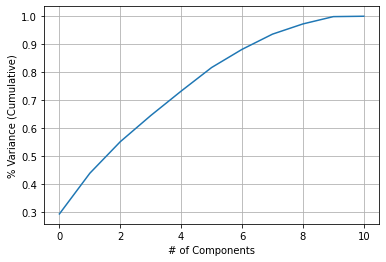

In [29]:
percent_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("# of Components")
plt.ylabel("% Variance (Cumulative)")
plt.show()

In [30]:
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [31]:
X_train_pca = pd.DataFrame(X_train_pca)

y_train = pd.DataFrame(y_train)
y_train.columns = y_raw.columns

# sklearn Linear Regression
skl_model = LinearRegression().fit(X_train_pca, y_train)

# Statsmodels OLS
stats_model = OLS(endog=y_train, exog=X_train_pca)
stats_model_results = stats_model.fit()
print(stats_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.274
Model:                            OLS   Adj. R-squared (uncentered):              0.273
Method:                 Least Squares   F-statistic:                              164.1
Date:                Thu, 13 Oct 2022   Prob (F-statistic):                   2.62e-264
Time:                        08:01:04   Log-Likelihood:                         -4931.5
No. Observations:                3918   AIC:                                      9881.
Df Residuals:                    3909   BIC:                                      9937.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Evaluate - Train

In [32]:
skl_model.score(X_train_pca, y_train)

0.2742336996011975

In [33]:
stats_model_results.rsquared

0.2742336996011975

In [34]:
y_pred = skl_model.predict(X_train_pca)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8519191865422463

In [35]:
y_pred = stats_model_results.predict(X_train_pca)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8519191865422463

#### Evaluate - Test

In [36]:
skl_model.score(X_test_pca, y_test)

0.2619419588830003

In [37]:
y_pred = skl_model.predict(X_test_pca)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.871381598123938

In [38]:
y_pred = stats_model_results.predict(X_test_pca)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.871381598123938

### Multicollinearity Removed (Ridge Regression)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.20, random_state=56)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

X_train = pd.DataFrame(X_train)
X_train.columns = X_raw.columns

y_train = pd.DataFrame(y_train)
y_train.columns = y_raw.columns

# sklearn Ridge Regression
skl_model = Ridge().fit(X_train, y_train)

# Statsmodels OLS Ridge Regression
stats_model = OLS(endog=y_train, exog=X_train)
stats_model_results = stats_model.fit_regularized(L1_wt=0)

#### Evaluate - Train

In [40]:
skl_model.score(X_train, y_train)

0.28628712100584264

In [41]:
y_pred = skl_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8448152928268744

In [42]:
y_pred = stats_model_results.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
rmse_train

0.8448140038984782

#### Evaluate - Test

In [43]:
skl_model.score(X_test, y_test)

0.2577597840756345

In [44]:
y_pred = skl_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.8738469341908232

In [45]:
y_pred = stats_model_results.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

0.8741340992285127